In [1]:
import numpy as np
import os
import pandas as pd
import copy
import matplotlib.pyplot as plt   
import seaborn as sns
import psycopg2
import pickle
from sklearn.svm import SVR
import warnings
warnings.filterwarnings("ignore")


In [2]:
connection = psycopg2.connect(database="edw_dev", user="postgres", password="AocAvalonPG123", host="52.15.157.95",port=5432)
cursor = connection.cursor()

In [3]:
data = pd.read_sql_query('select o.unique_case_id,o.patient_id ,o.order_id,o.administration_date ,o.gender ,o.age ,o.bmi ,o.cpt_code ,o.inpatient_or_outpatient ,o.procedure_name ,o.attending_physician ,o.drug_name ,o.drug_type ,p.master_procedure ,o.mme_medicationadministrated from edw_fact.dw_fact_oschner as o left join edw_dim.dw_dim_procedure as p on o.fk_procedure_id = p.procedure_id  ;',con=connection)
data.head()

,unique_case_id,patient_id,order_id,administration_date,gender,age,bmi,cpt_code,inpatient_or_outpatient,procedure_name,attending_physician,drug_name,drug_type,master_procedure,mme_medicationadministrated
0,857405,Z1828886,310196607,15-Nov-17,MALE,64,36.65,27447,Inpatient,"ARTHROPLASTY, KNEE",74917,HYDROMORPHONE MGML INJ UMBRELLA,INJ,"ARTHROPLASTY, KNEE",2.6
1,857405,Z1828886,310196607,15-Nov-17,MALE,64,36.65,27447,Inpatient,"ARTHROPLASTY, KNEE",74917,HYDROMORPHONE MGML INJ UMBRELLA,INJ,"ARTHROPLASTY, KNEE",2.6
2,857405,Z1828886,310244036,16-Nov-17,MALE,64,36.65,27447,Inpatient,"ARTHROPLASTY, KNEE",74917,OXYCODONE MG ORAL TAB,PO,"ARTHROPLASTY, KNEE",75.0
3,857405,Z1828886,310244036,15-Nov-17,MALE,64,36.65,27447,Inpatient,"ARTHROPLASTY, KNEE",74917,OXYCODONE MG ORAL TAB,PO,"ARTHROPLASTY, KNEE",75.0
4,857405,Z1828886,310244036,16-Nov-17,MALE,64,36.65,27447,Inpatient,"ARTHROPLASTY, KNEE",74917,OXYCODONE MG ORAL TAB,PO,"ARTHROPLASTY, KNEE",75.0


In [4]:
data.shape

(135651, 15)

In [5]:
data.isna().sum()

unique_case_id                     0
patient_id                         0
order_id                           0
administration_date            10252
gender                             0
age                                0
bmi                             1091
cpt_code                         753
inpatient_or_outpatient            0
procedure_name                     0
attending_physician                0
drug_name                          0
drug_type                          0
master_procedure                  96
mme_medicationadministrated        0
dtype: int64

In [6]:
data =  data.dropna()
data = data.drop_duplicates()
data.shape

(58088, 15)

In [7]:
data = data[data['drug_type']=='PO']
data.shape

(35821, 15)

In [8]:
a = list(data[data['bmi'] > 50].index)
len(a)

420

In [9]:
data = data.drop(a)

In [10]:
b = data[data['mme_medicationadministrated']>300].index
len(b)

557

In [11]:
data = data.drop(b)
data.shape

(34844, 15)

In [12]:
df = data[['administration_date','gender','age','bmi','inpatient_or_outpatient','attending_physician','master_procedure','mme_medicationadministrated']]
df = df.rename(columns={"attending_physician": "physician_name","mme_medicationadministrated":"mme_medication_administrated_perdayavg",'inpatient_or_outpatient':'patient_type','administration_date':'procedure date'})
df.head()

,procedure date,gender,age,bmi,patient_type,physician_name,master_procedure,mme_medication_administrated_perdayavg
2,16-Nov-17,MALE,64,36.65,Inpatient,74917,"ARTHROPLASTY, KNEE",75.0
3,15-Nov-17,MALE,64,36.65,Inpatient,74917,"ARTHROPLASTY, KNEE",75.0
6,15-Nov-17,MALE,64,36.65,Inpatient,74917,"ARTHROPLASTY, KNEE",37.5
13,27-Jun-17,FEMALE,69,24.56,Outpatient,4895,"ARTHROPLASTY, KNEE",112.5
19,28-Jun-17,FEMALE,69,24.56,Outpatient,4895,"ARTHROPLASTY, KNEE",112.5


In [13]:
len(df['master_procedure'].unique())

15

In [14]:
len(df['physician_name'].unique())

97

In [15]:
df['physician_name'].unique()

array(['74917', '4895', '4045', '88242', '686', '40895', '86851', '89860',
       '77447', '4722', '74071', '4868', '40816', '5909', '2590', '70865',
       '77353', '1956', '3521', '7456', '1887', '73299', '5320', '7523',
       '74886', '85360', '78519', '77798', '74906', '4540', '41924',
       '84517', '8724', '71217', '83611', '92095', '85323', '86149',
       '74799', '75580', '9066', '73799', '98278', '9445', '105013',
       '40888', '41578', '89855', '9038', '8455', '2325', '74584', '7249',
       '84528', '104172', '86402', '9340', '9314', '42054', '104173',
       '9190', '80904', '103501', '103811', '9511', '40893', '1939',
       '43038', '89147', '89960', '96154', '108074', '92094', '7521',
       '84098', '73435', '84487', '8728', '74677', '42055', '94403',
       '75500', '72489', '92358', '90824', '89412', '84865', '74681',
       '97550', '79557', '9026', '75579', '41519', '99599', '103500',
       '9225', '9238'], dtype=object)

In [16]:
def data_year(data,doctor,yearr,patient_type):
    
    A = data[data['physician_name'] == doctor]
    A = A[A['patient_type'] == patient_type]
    A['procedure date'] = pd.to_datetime(A['procedure date'])
    
    year = []
    month = []
    for i in A['procedure date']:
        a = i.year
        b = i.month
        year.append(a)
        month.append(b)
    A['Year'] = year
    A['Month'] = month
    
    B = A[A['Year'] == yearr]
    
    lowwer = []
    higher = []
    mediumm = []
    Month = []
    for i in list(range(1,13,1)):
        C =  B[B['Month'] == i].reset_index()
        Month.append(i)
        low = []
        medium = []
        high = []
        for j in range(C.shape[0]):
            if C['mme_medication_administrated_perdayavg'][j] < 50:
                low.append(C['mme_medication_administrated_perdayavg'][j])
            
            elif C['mme_medication_administrated_perdayavg'][j] < 100 and C['mme_medication_administrated_perdayavg'][j] > 50:
                medium.append(C['mme_medication_administrated_perdayavg'][j])
            
            else:
                high.append(C['mme_medication_administrated_perdayavg'][j])
        
        lowwer.append(len(low)/C.shape[0]*100 if len(low) != 0 else 0)
        mediumm.append(len(medium)/C.shape[0]*100 if len(low) != 0 else 0)
        higher.append(len(high)/C.shape[0]*100 if len(low) != 0 else 0)
    
    
    df = pd.DataFrame({'Month':Month,'Low':lowwer,'medium':mediumm,'high':higher})
    
    df['Month'].replace([1,2,3,4,5,6,7,8,9,10,11,12],['January','February','March','April','May','June','July','August','September','October','November','December'],inplace=True)
    
    ax = df.plot(x="Month", y=["Low","medium","high"], kind="bar",figsize=(15,5))
    

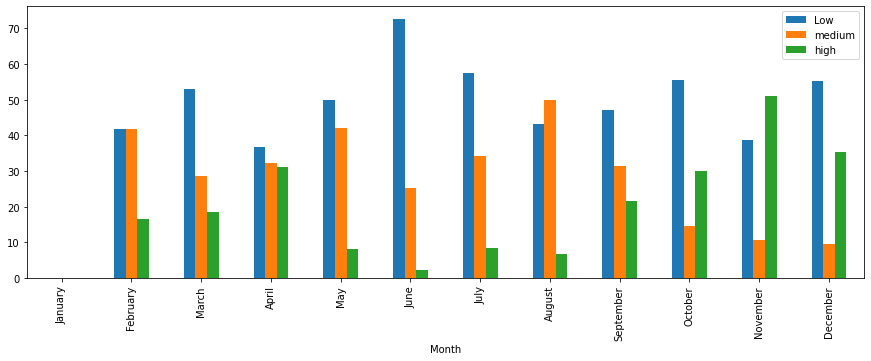

In [17]:
data_year(df,'1956',2018,'Inpatient')

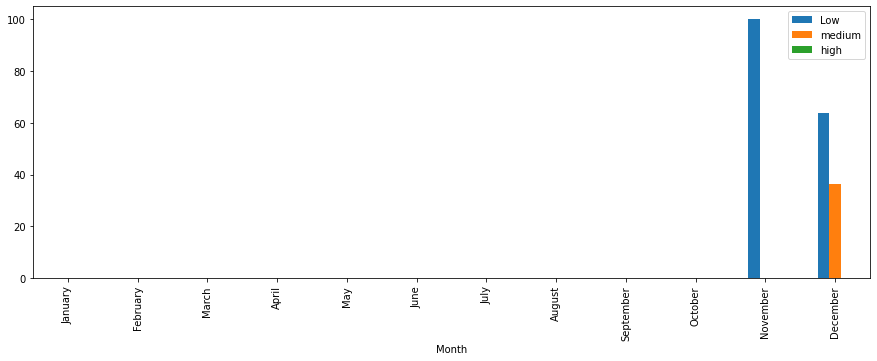

In [18]:
data_year(df,'9511',2020,'Inpatient')

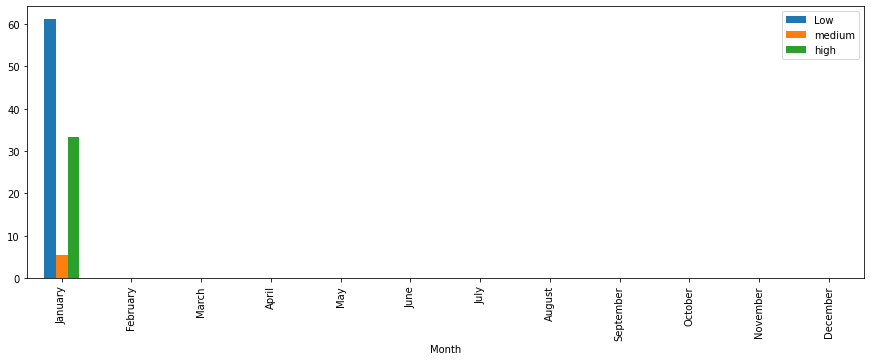

In [19]:
data_year(df,'77447',2018,'Inpatient')